In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

## Reading the emotions data (generated ChatGPT)

In [14]:
dataset = pd.read_csv("data/gpt_60_emotions.csv")

dataset = dataset.dropna()

dataset

,sentence,emotion
0,I can't believe they cancelled my flight witho...,anger
1,It's infuriating when people don't listen to s...,anger
2,How dare they blame me for their own mistake!,anger
3,The level of incompetence in this office is ju...,anger
4,"Every time I see the mess, it just makes my bl...",anger
...,...,...
361,The unexpected compliment brightened my day si...,surprise
362,I was taken aback by the depth of her insight.,surprise
363,The sudden downpour during our picnic was a su...,surprise
364,The unexpected twist in the movie left everyon...,surprise


In [15]:
# Display the value counts to verify
dataset['emotion'].value_counts()

emotion
anger        61
disgust      61
fear         61
happiness    61
sadness      61
surprise     61
Name: count, dtype: int64

## Splitting the data into train and test sets and encoding emotions

In [16]:
pd.get_dummies(dataset['emotion'], dtype='int')

,anger,disgust,fear,happiness,sadness,surprise
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
361,0,0,0,0,0,1
362,0,0,0,0,0,1
363,0,0,0,0,0,1
364,0,0,0,0,0,1


In [17]:
train_df, valid_df = train_test_split(dataset, test_size=0.15, stratify=dataset['emotion'], random_state=42)

In [18]:
train_df

,sentence,emotion
81,The conditions in which they keep these animal...,disgust
257,Feeling like I'm not living up to my potential...,sadness
261,The loneliness of being far from loved ones is...,sadness
303,"Turning the page on a calendar, knowing they'r...",sadness
92,I can't believe the levels of pollution they'r...,disgust
...,...,...
359,The surprise visit from my best friend made my...,surprise
212,The pleasure of a good conversation with a fri...,happiness
116,Their exploitation of trust is just vile.,disgust
106,Witnessing their blatant greed is sickening.,disgust


In [19]:
y_train_one_hot = pd.get_dummies(train_df['emotion'], dtype="int").values
y_val_one_hot = pd.get_dummies(valid_df['emotion'], dtype="int").values

In [20]:
y_train_one_hot

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0]])

In [21]:
with tf.device('/GPU:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['sentence'].values, y_train_one_hot))
  train_data = train_data.cache().shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)

  val_data = tf.data.Dataset.from_tensor_slices((valid_df['sentence'].values, y_val_one_hot))
  val_data = val_data.cache().batch(8).prefetch(tf.data.AUTOTUNE)

  for text, label in train_data.take(1):
    for i in range(5):
     print(text[i].numpy(), label[i].numpy())
     print()

b'Watching them dismiss crucial issues for personal gain is loathsome.' [0 1 0 0 0 0]

b'I felt a burst of joy when I got the job offer.' [0 0 0 1 0 0]

b'Seeing people in pain or distress without being able to ease their suffering is hard.' [0 0 0 0 1 0]

b'The stories of people going missing in the woods are chilling.' [0 0 1 0 0 0]

b"Feeling like I'm not living up to my potential is demoralizing." [0 0 0 0 1 0]



## Loading the BERT model and preparing to fine-tune


In [22]:
def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  preprocessor = hub.KerasLayer(
      "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
  encoder_inputs = preprocessor(text_input)
  encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2",
    trainable=True)
  outputs_enc = encoder(encoder_inputs)
  pooled_output = outputs_enc["pooled_output"]
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  dense = tf.keras.layers.Dense(128, activation="relu")(drop)
  outputs = tf.keras.layers.Dense(6, activation="softmax")(dense)
  return tf.keras.Model(text_input, outputs)

In [23]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_1[0][0]']                
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [25]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)  # Stop training if validation loss doesn't improve for 3 epochs

epochs = 20
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/20


39/39 [==============================] - 24s 234ms/step - loss: 1.4327 - accuracy: 0.4373 - val_loss: 0.6835 - val_accuracy: 0.8364
Epoch 2/20
39/39 [==============================] - 8s 210ms/step - loss: 0.4696 - accuracy: 0.8746 - val_loss: 0.2729 - val_accuracy: 0.9273
Epoch 3/20
39/39 [==============================] - 8s 210ms/step - loss: 0.1478 - accuracy: 0.9743 - val_loss: 0.1071 - val_accuracy: 0.9818
Epoch 4/20
39/39 [==============================] - 8s 210ms/step - loss: 0.0440 - accuracy: 0.9968 - val_loss: 0.1706 - val_accuracy: 0.9273
Epoch 5/20
39/39 [==============================] - 8s 210ms/step - loss: 0.0483 - accuracy: 0.9904 - val_loss: 0.1344 - val_accuracy: 0.9636
Epoch 6/20
39/39 [==============================] - 8s 210ms/step - loss: 0.0200 - accuracy: 0.9968 - val_loss: 0.0991 - val_accuracy: 0.9818
Epoch 7/20
39/39 [==============================] - 8s 211ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0511 - val_accuracy: 0.9818
Epoch 8/20
39/39

In [28]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

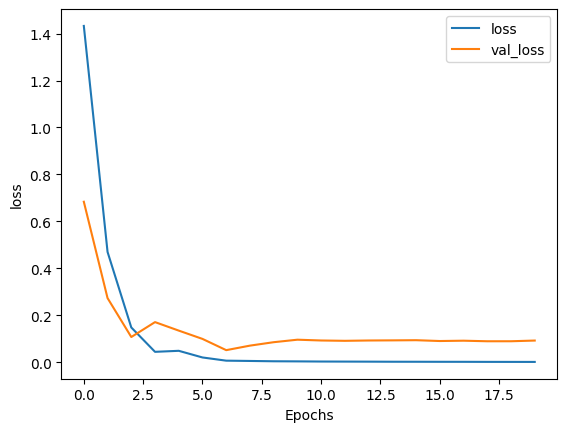

In [29]:
plot_graphs(history=history, metric='loss')

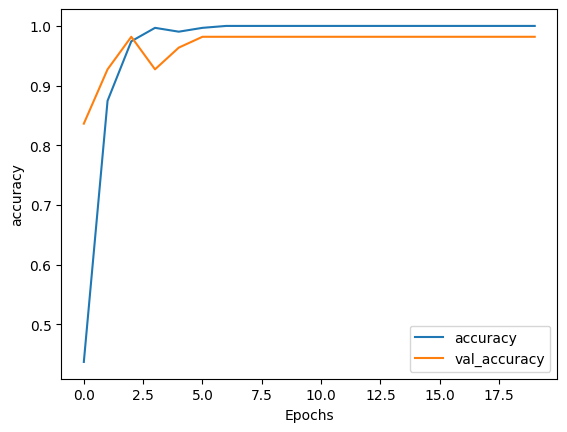

In [30]:
plot_graphs(history=history, metric='accuracy')

## Saving the model and applying predictions to kaggle

In [33]:
sample_example = ["I am revolted at the sight of rotten food"]
pred = model.predict(sample_example)

predicted_class_index = np.argmax(pred)

classes = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

predicted_class_label = classes[predicted_class_index]

print("Predicted Class Index:", predicted_class_index)
print("Predicted Class Label:", predicted_class_label)

1/1 [==============================] - 0s 48ms/step
Predicted Class Index: 1
Predicted Class Label: disgust


In [32]:
model.save('my_bert_gpt.h5')

In [34]:
model = tf.keras.models.load_model("my_bert_gpt.h5", custom_objects={'KerasLayer':hub.KerasLayer})

In [35]:
def emotion_from_message(message):
    classes = ['anger', 'disgust', 'fear','happiness','sadness','surprise']

    
    results = model.predict(np.expand_dims(message, 0))
    predicted_class_index = np.argmax(results)
    predicted_class_label = classes[predicted_class_index]

    print("Predicted Class Index:", predicted_class_index)
    print("Predicted Class Label:", predicted_class_label)
   
    return predicted_class_label

In [36]:
print(emotion_from_message("I heard strange noises outside my window late at night. My heart was racing, and I felt a sense of dread."))

1/1 [==============================] - 1s 971ms/step
Predicted Class Index: 2
Predicted Class Label: fear
fear


In [37]:
kaggle_data = pd.read_csv('data/kaggle_data.csv', sep='\t')
kaggle_data

,id,sentence
0,0,Girls are happy when they get flowers
1,1,His jaw dropped in disbelief when he saw the p...
2,2,Sometimes the ugly stench makes me wanna throw...
3,3,The foul odor from the garbage bin was disgust...
4,4,"I can’t believe it, they lost the game in the ..."
...,...,...
1431,1431,I feel guilty about the ice cream I stole as a...
1432,1432,Her ability to recall obscure facts never ceas...
1433,1433,"Your cat is so cute, I love him."
1434,1434,She remained skeptical about the new product.


In [41]:
kaggle_data['emotion'] = kaggle_data['sentence'].apply(emotion_from_message)

1/1 [==============================] - 0s 34ms/step
Predicted Class Index: 3
Predicted Class Label: happiness
1/1 [==============================] - 0s 29ms/step
Predicted Class Index: 5
Predicted Class Label: surprise
1/1 [==============================] - 0s 31ms/step
Predicted Class Index: 1
Predicted Class Label: disgust
1/1 [==============================] - 0s 30ms/step
Predicted Class Index: 1
Predicted Class Label: disgust
1/1 [==============================] - 0s 32ms/step
Predicted Class Index: 0
Predicted Class Label: anger
1/1 [==============================] - 0s 33ms/step
Predicted Class Index: 4
Predicted Class Label: sadness
1/1 [==============================] - 0s 32ms/step
Predicted Class Index: 1
Predicted Class Label: disgust
1/1 [==============================] - 0s 34ms/step
Predicted Class Index: 3
Predicted Class Label: happiness
1/1 [==============================] - 0s 32ms/step
Predicted Class Index: 4
Predicted Class Label: sadness
1/1 [====================

In [43]:
kaggle_data.value_counts('emotion')

emotion
surprise     315
anger        281
fear         250
happiness    228
sadness      206
disgust      156
Name: count, dtype: int64

In [44]:
# Creating new dataframe without the sentence column:
kaggle_submission = kaggle_data.drop('sentence', axis=1)

In [45]:
kaggle_submission.to_csv('submissions/submission_BERT_tuned_1.csv', index=False)

## Creating a web interface

In [82]:
import gradio as gr

c:\Users\franc\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [83]:
interface = gr.Interface(fn=emotion_from_message, 
                         inputs=gr.Textbox(lines=2, placeholder='Write your message here'),
                        outputs='text')

In [84]:
interface.launch(show_api=False)  

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 32ms/step
Predicted Class Index: 2
Predicted Class Label: fear
1/1 [==============================] - 0s 32ms/step
Predicted Class Index: 4
Predicted Class Label: sadness
